<a href="https://colab.research.google.com/github/VidithSomanna/Adv_AI/blob/main/AdvAI_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
# Cell 1 - Imports & helper functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils import check_array

# ART imports (install if missing)
try:
    from art.estimators.classification import SklearnClassifier
    from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent
except Exception:
    print('Installing adversarial-robustness-toolbox...')
    !pip install -q adversarial-robustness-toolbox
    from art.estimators.classification import SklearnClassifier
    from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent

# Helper: robust mean-abs SHAP extraction (handles Explainer/TreeExplainer returns)
def mean_abs_shap_for_explainer(explainer, X_eval, class_index=1):
    try:
        vals = explainer.shap_values(X_eval)
    except Exception:
        out = explainer(X_eval)
        vals = getattr(out, 'values', out)
    if isinstance(vals, (list, tuple)):
        if len(vals) > class_index:
            arr = np.abs(vals[class_index])
        else:
            arr = np.mean([np.abs(v) for v in vals], axis=0)
    else:
        vals = np.asarray(vals)
        if vals.ndim == 3:
            if vals.shape[0] > class_index:
                arr = np.abs(vals[class_index])
            else:
                arr = np.mean(np.abs(vals), axis=0)
        else:
            arr = np.abs(vals)
    return np.mean(arr, axis=0)

def save_fig(name):
    plt.savefig(name, dpi=300, bbox_inches='tight')
    print(f"Saved {name}")


In [17]:
# XAI robustness metric functions: Stability Index, ESD (Wasserstein), Kendall Tau-b
import numpy as np
from scipy.stats import wasserstein_distance, kendalltau

def stability_index(orig, adv, eps=1e-9):
    """
    Stability Index (SI): magnitude-aware similarity between two non-negative attribution vectors.
    SI = 1 - ||orig - adv||_1 / (||orig||_1 + ||adv||_1)
    Returns float in (-inf,1], where values closer to 1 indicate high stability.
    """
    orig = np.asarray(orig).astype(float)
    adv  = np.asarray(adv).astype(float)
    num = np.sum(np.abs(orig - adv))
    den = np.sum(np.abs(orig)) + np.sum(np.abs(adv)) + eps
    return 1.0 - (num / den)

def explanation_shift_distance(orig, adv):
    """
    Explanation Shift Distance (ESD): Wasserstein distance between orig and adv distributions.
    Assumes orig and adv are vectors of per-feature values. Lower = less shift.
    """
    orig = np.asarray(orig).astype(float)
    adv  = np.asarray(adv).astype(float)
    # Treat the arrays as distributions over features (weights = normalized positive magnitudes)
    # If negative values, shift to positive by absolute; then normalize
    orig_pos = np.abs(orig)
    adv_pos  = np.abs(adv)
    if orig_pos.sum() == 0:
        orig_w = np.ones_like(orig_pos) / len(orig_pos)
    else:
        orig_w = orig_pos / orig_pos.sum()
    if adv_pos.sum() == 0:
        adv_w = np.ones_like(adv_pos) / len(adv_pos)
    else:
        adv_w = adv_pos / adv_pos.sum()
    # compute 1-D discrete Wasserstein distance between the two weight vectors using feature index as coordinate
    coords = np.arange(len(orig_pos))
    return wasserstein_distance(coords, coords, u_weights=orig_w, v_weights=adv_w)

def kendall_tau(orig, adv):
    """
    Kendall's tau-b for ranking consistency (returns tau, p-value)
    More robust than Spearman for ties.
    """
    orig = np.asarray(orig).astype(float)
    adv  = np.asarray(adv).astype(float)
    tau, p = kendalltau(orig, adv)
    return tau, p


In [18]:
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/heart.csv"

import pandas as pd

df = pd.read_csv(path)
print(df.shape)
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [19]:
from sklearn.model_selection import train_test_split

# Separate features & target
X = df.drop("target", axis=1)
y = df["target"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
print('Scaling complete.')


Scaling complete.


In [21]:
# Train models: LogisticRegression (for gradient attacks) and RandomForest (tree baseline)
log_reg = LogisticRegression(max_iter=1000, random_state=42)
rf = RandomForestClassifier(n_estimators=200, random_state=42)

# Logistic uses scaled features; RandomForest uses original features
log_reg.fit(X_train_scaled, y_train)
rf.fit(X_train, y_train)

print('Trained LogisticRegression and RandomForest.')


Trained LogisticRegression and RandomForest.


In [22]:
# Baseline evaluation on test set
def evaluate(model, Xt, yt, name='model'):
    preds = model.predict(Xt)
    probs = None
    try:
        probs = model.predict_proba(Xt)[:,1]
    except Exception:
        pass
    acc = accuracy_score(yt, preds)
    prec = precision_score(yt, preds, zero_division=0)
    rec = recall_score(yt, preds, zero_division=0)
    f1 = f1_score(yt, preds, zero_division=0)
    roc = roc_auc_score(yt, probs) if probs is not None else float('nan')
    print(f'[{name}] Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}, ROC-AUC={roc:.4f}')
    return {'acc':acc,'prec':prec,'rec':rec,'f1':f1,'roc':roc}

print('LogisticRegression (scaled inputs):')
metrics_lr = evaluate(log_reg, X_test_scaled, y_test, 'LogisticRegression')
print('\nRandomForest (original inputs):')
metrics_rf = evaluate(rf, X_test, y_test, 'RandomForest')


LogisticRegression (scaled inputs):
[LogisticRegression] Acc=0.7951, Prec=0.7563, Rec=0.8738, F1=0.8108, ROC-AUC=0.8787

RandomForest (original inputs):
[RandomForest] Acc=0.9854, Prec=1.0000, Rec=0.9709, F1=0.9852, ROC-AUC=1.0000


Saved shap_summary_lr.png


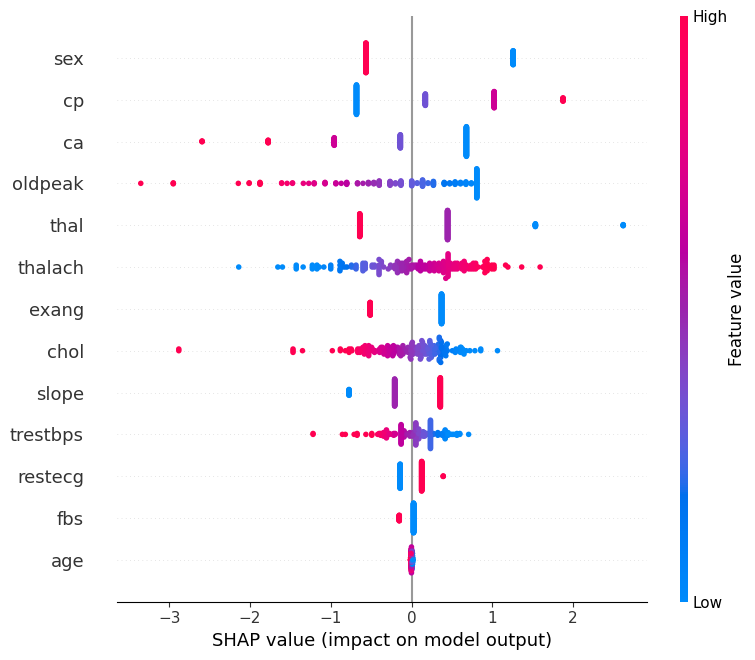

In [23]:
# SHAP baseline for LogisticRegression (scaled inputs)
explainer_lr = shap.Explainer(log_reg, X_train_scaled)
shap_orig_lr = explainer_lr(X_test_scaled)
# summary plot
shap.summary_plot(shap_orig_lr, X_test_scaled, show=False)
save_fig('shap_summary_lr.png')


Saved shap_summary_rf.png


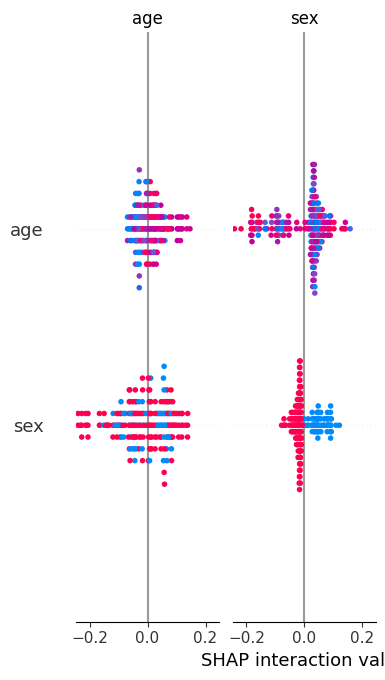

In [24]:
# SHAP baseline for RandomForest (unscaled)
try:
    expl_rf = shap.TreeExplainer(rf)
    shap_vals_rf = expl_rf.shap_values(X_test)
    shap.summary_plot(shap_vals_rf, X_test, show=False)
    save_fig('shap_summary_rf.png')
except Exception as e:
    print('TreeExplainer failed for RF:', e)
    bg = shap.sample(X_train, min(100, X_train.shape[0]), random_state=42)
    expl_rf = shap.KernelExplainer(rf.predict_proba, bg)
    shap_vals_rf = expl_rf.shap_values(X_test.iloc[:200])
    shap.summary_plot(shap_vals_rf, X_test.iloc[:200], show=False)
    save_fig('shap_summary_rf_kernel.png')


In [25]:
# Save baseline mean-abs SHAP per feature (LR)
base_shap_lr = np.abs(shap_orig_lr.values).mean(axis=0)
df_base_lr = pd.DataFrame({'Feature': X_test_scaled.columns, 'MeanAbsSHAP': base_shap_lr}).sort_values('MeanAbsSHAP', ascending=False)
df_base_lr.to_csv('base_shap_lr.csv', index=False)
print('Saved base_shap_lr.csv')


Saved base_shap_lr.csv


In [26]:
# Generate adversarials (FGSM tried across eps list; PGD fallback)
from art.estimators.classification import SklearnClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent
assert 'log_reg' in globals(), 'log_reg must be defined'
Xs = (X_test_scaled.to_numpy()).astype('float32')
art_clf = SklearnClassifier(model=log_reg)

eps_list = [0.01, 0.05, 0.1, 0.15, 0.2]
selected = None
for eps in eps_list:
    try:
        atk = FastGradientMethod(estimator=art_clf, eps=eps)
        X_adv_try = atk.generate(Xs)
    except Exception as e:
        print('FGSM failed for eps', eps, e)
        continue
    preds_orig = log_reg.predict(Xs)
    preds_adv  = log_reg.predict(X_adv_try)
    unchanged_pct = 100*np.mean(preds_orig==preds_adv)
    mean_abs = np.mean(np.abs(X_adv_try - Xs))
    print(f'FGSM eps={eps} -> mean_abs={mean_abs:.6e}, unchanged%={unchanged_pct:.2f}')
    if unchanged_pct < 95.0:
        selected = ('fgsm', eps, X_adv_try)
        break
if selected is None:
    print('FGSM insufficient; trying PGD...')
    try:
        atk = ProjectedGradientDescent(estimator=art_clf, eps=0.15, eps_step=0.02, max_iter=40)
        X_adv_pgd = atk.generate(Xs)
        preds_adv = log_reg.predict(X_adv_pgd)
        unchanged_pct = 100*np.mean(preds_orig==preds_adv)
        mean_abs = np.mean(np.abs(X_adv_pgd - Xs))
        print(f'PGD -> mean_abs={mean_abs:.6e}, unchanged%={unchanged_pct:.2f}')
        if unchanged_pct < 98.0:
            selected = ('pgd', 0.15, X_adv_pgd)
    except Exception as e:
        print('PGD failed:', e)
if selected is None:
    X_adv_final = X_adv_try
    print('Using fallback FGSM output.')
else:
    used_method, used_eps, X_adv_final = selected
    print('Selected attack', used_method, used_eps)
# Save as DataFrame with scaled columns
X_adv = pd.DataFrame(X_adv_final, columns=X_test_scaled.columns)
X_adv.to_csv('X_adv_generated.csv', index=False)
print('Saved X_adv_generated.csv')


FGSM eps=0.01 -> mean_abs=9.999992e-03, unchanged%=98.05
FGSM eps=0.05 -> mean_abs=4.999999e-02, unchanged%=90.24
Selected attack fgsm 0.05
Saved X_adv_generated.csv


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist

In [27]:
# Sanity checks for adversarial set (run right after Cell 10)
def to_np(X):
    return X.values if hasattr(X, 'values') else np.asarray(X)
Xs = to_np(X_test_scaled).astype(float)
Xa = to_np(X_adv).astype(float)
mean_abs_perturb = np.mean(np.abs(Xa - Xs))
max_abs_perturb = np.max(np.abs(Xa - Xs))
print('mean abs perturb:', mean_abs_perturb, 'max abs perturb:', max_abs_perturb)
if 'log_reg' in globals():
    print('LogReg % unchanged:', 100*np.mean(log_reg.predict(Xs) == log_reg.predict(Xa)))
if 'rf' in globals():
    try:
        df_adv_tree = pd.DataFrame(Xa, columns=X_test.columns)
        print('RF % unchanged:', 100*np.mean(rf.predict(X_test) == rf.predict(df_adv_tree)))
    except Exception as e:
        print('RF predict check failed:', e)


mean abs perturb: 0.049999997271982545 max abs perturb: 0.05000016877538993
LogReg % unchanged: 90.2439024390244
RF % unchanged: 72.1951219512195


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [28]:
# SHAP original vs adversarial for LogisticRegression (scaled)
explainer_lr = shap.Explainer(log_reg, X_train_scaled)
shap_orig_lr = explainer_lr(X_test_scaled)
shap_adv_lr  = explainer_lr(X_adv)
base_shap_mean = np.abs(shap_orig_lr.values).mean(axis=0)
adv_shap_mean  = np.abs(shap_adv_lr.values).mean(axis=0)
df_lr = pd.DataFrame({'Feature': X_test_scaled.columns, 'Original_SHAP': base_shap_mean, 'Adversarial_SHAP': adv_shap_mean})
df_lr['Change'] = np.abs(df_lr['Original_SHAP'] - df_lr['Adversarial_SHAP'])
df_lr['Change_%'] = 100*df_lr['Change']/(df_lr['Original_SHAP']+1e-9)
df_lr = df_lr.sort_values('Change_%', ascending=False).reset_index(drop=True)
df_lr.head(15)


,Feature,Original_SHAP,Adversarial_SHAP,Change,Change_%
0,cp,0.746141,0.720431,0.025711,3.445838
1,exang,0.414032,0.402040,0.011992,2.896415
2,thalach,0.544865,0.529401,0.015464,2.838062
3,thal,0.636593,0.619451,0.017142,2.692827
4,slope,0.333169,0.324202,0.008967,2.691501
5,oldpeak,0.673911,0.656411,0.017499,2.596659
6,ca,0.683161,0.665591,0.017571,2.571951
7,age,0.005215,0.005140,0.000075,1.436899
8,restecg,0.136317,0.134977,0.001339,0.982536
9,sex,0.788406,0.781272,0.007134,0.904831


In [29]:
#Compute RF SHAP robustly, then compute modern robustness summary for LR & RF
import numpy as np
import pandas as pd
from scipy.stats import spearmanr

#  1) Robust RF SHAP (same logic as before, but included here for single-run convenience)
# requires: rf, X_test, X_adv (X_adv may be scaled; code will try to align/inverse-transform if scaler exists)
if 'rf' not in globals():
    raise RuntimeError("RandomForest 'rf' not found. Train rf before running this cell.")
if 'X_test' not in globals():
    raise RuntimeError("X_test not found. Run preprocessing / split first.")
if 'X_adv' not in globals():
    raise RuntimeError("X_adv not found. Generate adversarial set first (Cell 11).")

# Build X_adv_df aligned to X_test columns
if isinstance(X_adv, pd.DataFrame):
    X_adv_df = X_adv.copy()
else:
    try:
        X_adv_df = pd.DataFrame(X_adv, columns=X_test.columns)
    except Exception:
        if 'scaler' in globals():
            try:
                inv = scaler.inverse_transform(X_adv)
                X_adv_df = pd.DataFrame(inv, columns=X_test.columns)
                print("Used scaler.inverse_transform to convert X_adv to unscaled features.")
            except Exception:
                X_adv_df = pd.DataFrame(X_adv)
        else:
            X_adv_df = pd.DataFrame(X_adv)

# Align columns if necessary
if list(X_adv_df.columns) != list(X_test.columns):
    print("WARNING: X_adv columns differ from X_test columns. Aligning by position.")
    X_adv_df.columns = X_test.columns

# Compute TreeExplainer SHAP values
expl_rf = shap.TreeExplainer(rf)
shap_orig_rf = expl_rf.shap_values(X_test)
shap_adv_rf  = expl_rf.shap_values(X_adv_df)

# Robust collapse helper (handles list/3d shapes)
def mean_abs_per_feature_from_shap(shap_out, n_features, class_index=1):
    arr = shap_out
    if isinstance(shap_out, (list, tuple)):
        try:
            sel = shap_out[class_index]
            arr = np.asarray(sel)
        except Exception:
            arr = np.asarray(shap_out)
    else:
        arr = np.asarray(shap_out)

    if arr.ndim == 1:
        return np.abs(arr)
    if arr.ndim == 2:
        return np.abs(arr).mean(axis=0)
    if arr.ndim == 3:
        # if shape (n_samples, n_features, n_classes) -> select class_index
        if arr.shape[1] == n_features:
            try:
                sel = arr[:, :, class_index]
                return np.abs(sel).mean(axis=0)
            except Exception:
                arr2 = arr.reshape(-1, arr.shape[-1])
                return np.abs(arr2).mean(axis=0)
        elif arr.shape[-1] == n_features:
            arr2 = arr.reshape(-1, arr.shape[-1])
            return np.abs(arr2).mean(axis=0)
        else:
            arr2 = arr.reshape(-1, arr.shape[-1])
            return np.abs(arr2).mean(axis=0)

    arr2 = arr.reshape(-1, arr.shape[-1])
    return np.abs(arr2).mean(axis=0)

n_features = X_test.shape[1]
orig_vals = mean_abs_per_feature_from_shap(shap_orig_rf, n_features=n_features, class_index=1)
adv_vals  = mean_abs_per_feature_from_shap(shap_adv_rf,  n_features=n_features, class_index=1)

print("DEBUG: shap_orig_rf raw shape:", np.asarray(shap_orig_rf).shape, " -> collapsed:", orig_vals.shape)
print("DEBUG: shap_adv_rf raw shape :", np.asarray(shap_adv_rf).shape,  " -> collapsed:", adv_vals.shape)

if orig_vals.shape[0] != n_features or adv_vals.shape[0] != n_features:
    raise ValueError(f"Feature-length mismatch after collapse: orig {orig_vals.shape[0]}, adv {adv_vals.shape[0]}, expected {n_features}")

df_rf = pd.DataFrame({
    'Feature': list(X_test.columns),
    'Original_SHAP': orig_vals,
    'Adversarial_SHAP': adv_vals
})
df_rf['Change'] = np.abs(df_rf['Original_SHAP'] - df_rf['Adversarial_SHAP'])
df_rf['Change_%'] = 100 * df_rf['Change'] / (df_rf['Original_SHAP'] + 1e-9)
df_rf = df_rf.sort_values('Change_%', ascending=False).reset_index(drop=True)

print("RandomForest SHAP comparison produced: df_rf (top 10):")
display(df_rf.head(10))

# 2) Modern robustness metrics summary (use df_lr and df_rf if available)
# requires: df_lr (from LogisticRegression SHAP comparison) – if not present, the summary will only include RF
if 'df_lr' not in globals():
    print("Warning: df_lr (LogReg SHAP comparison) not found. Only RF will be included in summary.")

def compute_modern_metrics(df, model_name='Model'):
    orig = df['Original_SHAP'].values
    adv  = df['Adversarial_SHAP'].values
    SI = stability_index(orig, adv)
    ESD = explanation_shift_distance(orig, adv)
    tau, pval = kendall_tau(orig, adv)
    sp = spearmanr(orig, adv).correlation
    # legacy top-5 jaccard for reference
    topk = 5
    top_orig = set(df.nlargest(topk, 'Original_SHAP')['Feature'])
    top_adv  = set(df.nlargest(topk, 'Adversarial_SHAP')['Feature'])
    jaccard_top5 = len(top_orig & top_adv) / len(top_orig | top_adv) if len(top_orig | top_adv) > 0 else np.nan
    masd = float(np.mean(np.abs(orig - adv)))
    mean_pert = globals().get('mean_abs_perturb', float('nan'))
    return {
        'Model': model_name,
        'SI': SI,
        'ESD': ESD,
        'KendallTau': tau,
        'Kendall_p': pval,
        'Spearman': sp,
        'Jaccard_Top5': jaccard_top5,
        'MeanAbsSHAPDev': masd,
        'MeanAbsPerturb': mean_pert
    }

rows = []
if 'df_lr' in globals():
    rows.append(compute_modern_metrics(df_lr, model_name='LogisticRegression'))
rows.append(compute_modern_metrics(df_rf, model_name='RandomForest'))

summary_df = pd.DataFrame(rows)
summary_df.to_csv('shap_robustness_summary.csv', index=False)
print("Saved shap_robustness_summary.csv with modern metrics:")
display(summary_df)


DEBUG: shap_orig_rf raw shape: (205, 13, 2)  -> collapsed: (13,)
DEBUG: shap_adv_rf raw shape : (205, 13, 2)  -> collapsed: (13,)
RandomForest SHAP comparison produced: df_rf (top 10):


,Feature,Original_SHAP,Adversarial_SHAP,Change,Change_%
0,thalach,0.051670,0.117906,0.066236,128.189535
1,trestbps,0.019420,0.032371,0.012951,66.690327
2,fbs,0.003509,0.001296,0.002213,63.060898
3,thal,0.097468,0.038422,0.059046,60.579719
4,chol,0.029149,0.011528,0.017621,60.451788
5,restecg,0.012613,0.006925,0.005687,45.091412
6,age,0.036842,0.020457,0.016386,44.475437
7,slope,0.039907,0.022828,0.017079,42.796225
8,sex,0.033893,0.037933,0.004040,11.920670
9,exang,0.046879,0.051372,0.004493,9.584918


Saved shap_robustness_summary.csv with modern metrics:


,Model,SI,ESD,KendallTau,Kendall_p,Spearman,Jaccard_Top5,MeanAbsSHAPDev,MeanAbsPerturb
0,LogisticRegression,0.988580,0.033628,1.000000,3.211809e-10,1.000000,1.000000,0.009779,0.05
1,RandomForest,0.821026,0.555597,0.717949,2.839785e-04,0.862637,0.666667,0.017220,0.05


In [31]:
# Ensure the variable used for plotting exists and points to the intended SHAP comparison
if 'df_lr' in globals():
    robustness_adv_df = df_lr.copy()
    print("Plotting using df_lr (LogisticRegression) as robustness_adv_df")
elif 'df_rf' in globals():
    robustness_adv_df = df_rf.copy()
    print("df_lr not found — plotting using df_rf (RandomForest) as robustness_adv_df")
else:
    raise RuntimeError("Neither df_lr nor df_rf found. Run the SHAP comparison cells first (Cell 13 for df_lr / RF SHAP cell for df_rf).")


Plotting using df_lr (LogisticRegression) as robustness_adv_df


Saved shap_orig_vs_adv_scatter.png


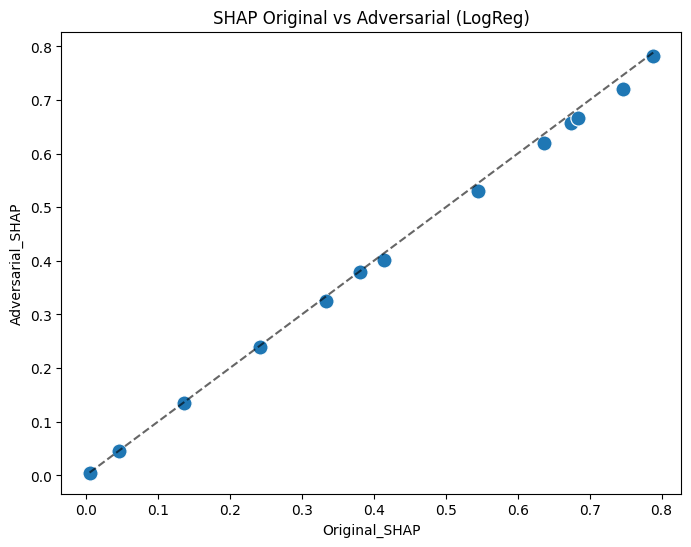

/tmp/ipython-input-3974103177.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=robustness_adv_df.head(10), x='Change_%', y='Feature', palette='magma')


Saved top10_change_adv.png


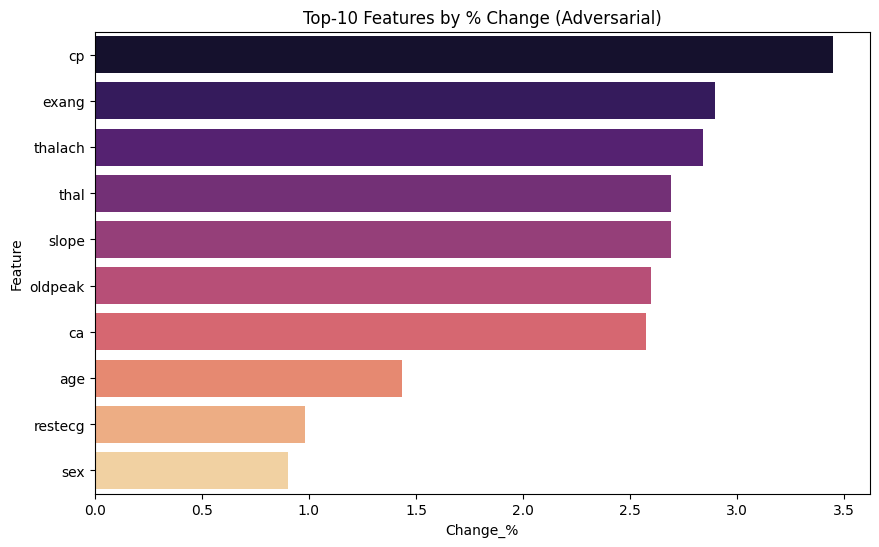

In [32]:
#  Plots: scatter and top-change bar
plt.figure(figsize=(8,6))
sns.scatterplot(data=robustness_adv_df, x='Original_SHAP', y='Adversarial_SHAP', s=120)
mn = min(robustness_adv_df['Original_SHAP'].min(), robustness_adv_df['Adversarial_SHAP'].min())
mx = max(robustness_adv_df['Original_SHAP'].max(), robustness_adv_df['Adversarial_SHAP'].max())
plt.plot([mn,mx],[mn,mx],'k--',alpha=0.6)
plt.title('SHAP Original vs Adversarial (LogReg)')
save_fig('shap_orig_vs_adv_scatter.png')
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(data=robustness_adv_df.head(10), x='Change_%', y='Feature', palette='magma')
plt.title('Top-10 Features by % Change (Adversarial)')
save_fig('top10_change_adv.png')
plt.show()


Running eps = 0.01
eps 0.01: SI=0.9977, ESD=0.0033, Kendall=1.0000, Spearman=1.0000, Jaccard=1.000
Running eps = 0.03
eps 0.03: SI=0.9932, ESD=0.0098, Kendall=1.0000, Spearman=1.0000, Jaccard=1.000
Running eps = 0.05
eps 0.05: SI=0.9886, ESD=0.0166, Kendall=1.0000, Spearman=1.0000, Jaccard=1.000
Running eps = 0.1


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist

eps 0.1: SI=0.9772, ESD=0.0344, Kendall=1.0000, Spearman=1.0000, Jaccard=1.000
Running eps = 0.2
eps 0.2: SI=0.9559, ESD=0.0684, Kendall=0.9744, Spearman=0.9945, Jaccard=1.000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist

,Epsilon,SI,ESD,KendallTau,Kendall_p,Spearman,Jaccard_Top5
0,0.01,0.997710,0.003265,1.000000,3.211809e-10,1.000000,1.0
1,0.03,0.993150,0.009800,1.000000,3.211809e-10,1.000000,1.0
2,0.05,0.988580,0.016565,1.000000,3.211809e-10,1.000000,1.0
3,0.10,0.977196,0.034358,1.000000,3.211809e-10,1.000000,1.0
4,0.20,0.955851,0.068403,0.974359,4.175351e-09,0.994505,1.0


Saved robustness_modern_curve.png


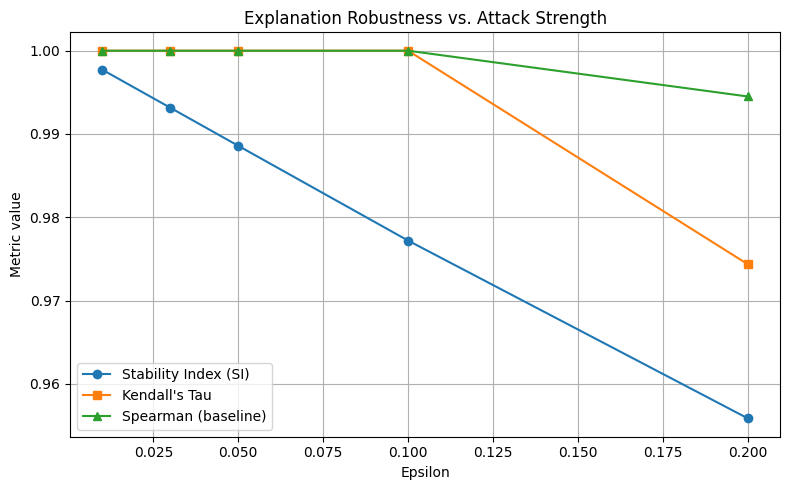

Saved robustness_esd_curve.png


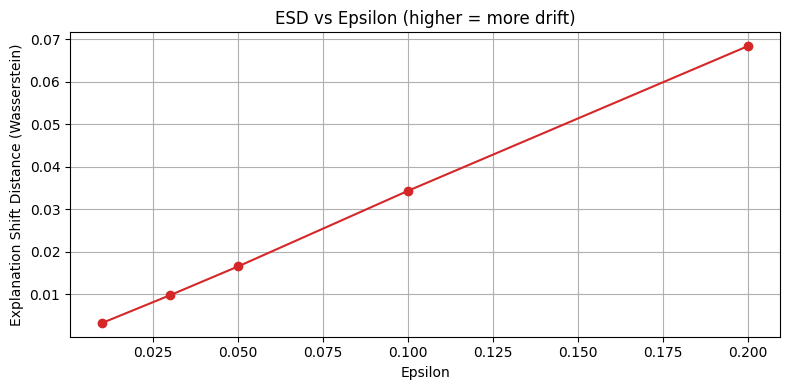

In [33]:
# Robustness curve across epsilons using SI, ESD, Kendall (for LogisticRegression / differentiable model)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from art.estimators.classification import SklearnClassifier
from art.attacks.evasion import FastGradientMethod

# --- sanity checks: required variables
assert 'log_reg' in globals(), "log_reg must exist (trained)."
assert 'X_train_scaled' in globals() and 'X_test_scaled' in globals(), "Scaled data required."

# Wrap logistic model for ART
art_clf = SklearnClassifier(model=log_reg)
explainer = shap.Explainer(log_reg, X_train_scaled)   # use scaled explainer for LR

# Choose epsilons to sweep; tune as needed
eps_values = [0.01, 0.03, 0.05, 0.1, 0.2]
results = []

# Base SHAP (original)
base_shap = np.abs(explainer(X_test_scaled).values).mean(axis=0)

for eps in eps_values:
    print("Running eps =", eps)
    try:
        atk = FastGradientMethod(estimator=art_clf, eps=eps)
        X_adv_np = atk.generate((X_test_scaled.to_numpy()).astype(np.float32))
    except Exception as e:
        print("Attack failed for eps", eps, ":", e)
        continue

    # compute SHAP on adv set (same representation)
    shap_adv_vals = np.abs(explainer(X_adv_np).values).mean(axis=0)

    # compute modern metrics
    SI = stability_index(base_shap, shap_adv_vals)
    ESD = explanation_shift_distance(base_shap, shap_adv_vals)
    tau, pval = kendall_tau(base_shap, shap_adv_vals)
    spearman_corr = spearmanr(base_shap, shap_adv_vals).correlation

    # top-5 jaccard (kept for legacy comparison)
    topk = 5
    top_base = set(pd.Series(base_shap, index=X_test_scaled.columns).nlargest(topk).index)
    top_adv  = set(pd.Series(shap_adv_vals, index=X_test_scaled.columns).nlargest(topk).index)
    jaccard_top5 = len(top_base & top_adv)/len(top_base | top_adv)

    results.append({
        'Epsilon': eps,
        'SI': SI,
        'ESD': ESD,
        'KendallTau': tau,
        'Kendall_p': pval,
        'Spearman': spearman_corr,
        'Jaccard_Top5': jaccard_top5
    })
    print(f"eps {eps}: SI={SI:.4f}, ESD={ESD:.4f}, Kendall={tau:.4f}, Spearman={spearman_corr:.4f}, Jaccard={jaccard_top5:.3f}")

# Save and display results
robust_df = pd.DataFrame(results)
robust_df.to_csv("shap_modern_robustness_curve.csv", index=False)
display(robust_df)

# Plot the metrics in two plots
plt.figure(figsize=(8,5))
plt.plot(robust_df['Epsilon'], robust_df['SI'], marker='o', label='Stability Index (SI)')
plt.plot(robust_df['Epsilon'], robust_df['KendallTau'], marker='s', label="Kendall's Tau")
plt.plot(robust_df['Epsilon'], robust_df['Spearman'], marker='^', label='Spearman (baseline)')
plt.xlabel('Epsilon')
plt.ylabel('Metric value')
plt.title('Explanation Robustness vs. Attack Strength')
plt.legend()
plt.grid(True)
plt.tight_layout()
save_fig('robustness_modern_curve.png')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(robust_df['Epsilon'], robust_df['ESD'], marker='o', color='tab:red')
plt.xlabel('Epsilon')
plt.ylabel('Explanation Shift Distance (Wasserstein)')
plt.title('ESD vs Epsilon (higher = more drift)')
plt.grid(True)
plt.tight_layout()
save_fig('robustness_esd_curve.png')
plt.show()


In [34]:
# Manual perturbation targeted to top features (for tree models)
import numpy as np
import pandas as pd

if 'df_rf' not in globals():
    print('df_rf not computed; run tree SHAP first.')
else:
    # choose top features to perturb (top 3 by change)
    top_feats = list(df_rf.head(3)['Feature'])
    print('Top features:', top_feats)

    # Make a copy to avoid mutating original test set
    X_adv_manual = X_test.copy().reset_index(drop=True)   # reset index so .iloc position matches row position

    # Number of rows to modify (30% of dataset)
    rows_to_modify = int(0.3 * len(X_adv_manual))
    rng = np.random.default_rng(seed=42)   # reproducible
    inds = rng.choice(len(X_adv_manual), size=rows_to_modify, replace=False)

    # Apply per-feature perturbation by positional indexing (iloc)
    for f in top_feats:
        if f not in X_adv_manual.columns:
            print(f"Warning: feature '{f}' not in X_test columns — skipping.")
            continue
        delta = 0.2 * X_adv_manual[f].std()
        # find the column position
        col_pos = X_adv_manual.columns.get_loc(f)
        # Use iloc to add delta to selected rows (positional)
        X_adv_manual.iloc[inds, col_pos] = X_adv_manual.iloc[inds, col_pos] + delta

    # Save and expose
    X_adv_tree = X_adv_manual
    X_adv_tree.to_csv('X_adv_tree_manual.csv', index=False)
    print(f"Saved manual tree perturbations to X_adv_tree_manual.csv (modified {rows_to_modify} rows).")


Top features: ['thalach', 'trestbps', 'fbs']
Saved manual tree perturbations to X_adv_tree_manual.csv (modified 61 rows).


/tmp/ipython-input-3966119296.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[169.66955851 146.66955851 182.66955851 137.66955851 147.66955851
 160.66955851 146.66955851  75.66955851 109.66955851 162.66955851
 138.66955851 136.66955851 145.66955851 166.66955851 179.66955851
 166.66955851 174.66955851 161.66955851 166.66955851 121.66955851
 182.66955851 155.66955851 144.66955851 169.66955851 146.66955851
 129.66955851 119.66955851 129.66955851 160.66955851 184.66955851
 183.66955851 161.66955851 155.66955851 115.66955851 169.66955851
 103.66955851 153.66955851 115.66955851 147.66955851 181.66955851
 163.66955851 160.66955851 160.66955851 158.66955851 166.66955851
 124.66955851 177.66955851 144.66955851 172.66955851 173.66955851
 109.66955851 183.66955851 176.66955851 158.66955851 152.66955851
 136.66955851  94.66955851 148.66955851 146.66955851 148.66955851
 152.66955851]' has dtype incompatible wit

In [35]:
# Recompute SHAP for RF using manual perturbations if created
if 'X_adv_tree' in globals():
    try:
        expl_rf = shap.TreeExplainer(rf)
        shap_adv_rf_manual = expl_rf.shap_values(X_adv_tree)
        if isinstance(shap_adv_rf_manual, list):
            adv_vals_m = np.abs(shap_adv_rf_manual[1]).mean(axis=0)
        else:
            adv_vals_m = np.abs(shap_adv_rf_manual).mean(axis=0)
        print('Recomputed SHAP on manually perturbed tree data.')
    except Exception as e:
        print('Tree SHAP failed on manual adv:', e)
else:
    print('No X_adv_tree found.')


Recomputed SHAP on manually perturbed tree data.


In [36]:
# Save CSVs and key PNGs check
import os
import pandas as pd

files_to_check = [
    'base_shap_lr.csv',
    'X_adv_generated.csv',
    'X_adv_tree_manual.csv',
    'shap_robustness_summary.csv',
    'shap_modern_robustness_curve.csv'  # robustness sweep filename if you ran M2
]

for fname in files_to_check:
    print(f"{fname} ->", os.path.exists(fname))

print("\nContents of shap_robustness_summary.csv (if present):")
try:
    display(pd.read_csv('shap_robustness_summary.csv'))
except Exception as e:
    print("Could not display shap_robustness_summary.csv:", e)

print("\nIf you want the robustness curve CSV, look for 'shap_modern_robustness_curve.csv' (saved by the eps sweep cell).")


base_shap_lr.csv -> True
X_adv_generated.csv -> True
X_adv_tree_manual.csv -> True
shap_robustness_summary.csv -> True
shap_modern_robustness_curve.csv -> True

Contents of shap_robustness_summary.csv (if present):


,Model,SI,ESD,KendallTau,Kendall_p,Spearman,Jaccard_Top5,MeanAbsSHAPDev,MeanAbsPerturb
0,LogisticRegression,0.988580,0.033628,1.000000,3.211809e-10,1.000000,1.000000,0.009779,0.05
1,RandomForest,0.821026,0.555597,0.717949,2.839785e-04,0.862637,0.666667,0.017220,0.05



If you want the robustness curve CSV, look for 'shap_modern_robustness_curve.csv' (saved by the eps sweep cell).


In [37]:
#  Utility: load saved CSVs if needed
def load_summary():
    try:
        df = pd.read_csv('shap_robustness_summary.csv')
        print(df)
    except Exception as e:
        print('Could not load shap_robustness_summary.csv:', e)
load_summary()


                Model        SI       ESD  KendallTau     Kendall_p  Spearman  \
0  LogisticRegression  0.988580  0.033628    1.000000  3.211809e-10  1.000000   
1        RandomForest  0.821026  0.555597    0.717949  2.839785e-04  0.862637   

   Jaccard_Top5  MeanAbsSHAPDev  MeanAbsPerturb  
0      1.000000        0.009779            0.05  
1      0.666667        0.017220            0.05  


In [38]:
# Utility: quick inspect of adv samples
try:
    display(pd.read_csv('X_adv_generated.csv').head())
except Exception as e:
    print('X_adv not saved or not found:', e)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,0.883168,-1.477525,-0.966720,-0.388694,-0.676281,-0.364039,0.859846,0.545660,-0.675949,-0.862152,0.955264,-0.675467,-0.495193
1,-0.099222,-1.477525,0.958275,-0.161520,-0.535261,-0.364039,-1.033742,-1.549156,-0.675949,-0.862152,0.955264,-0.675467,-3.806737
2,0.019087,0.604654,-0.866720,1.555865,0.835384,-0.464039,-0.933742,-0.139896,1.327507,-0.260661,-0.590078,0.190252,1.060579
3,-0.426686,-1.477525,-0.004223,-0.615867,0.028822,-0.364039,0.859846,0.502018,-0.675949,0.102398,0.955264,-0.675467,-0.495193
4,-0.744995,0.604654,-0.866720,-0.147934,0.170572,2.365230,-0.933742,0.078314,1.327507,-0.962152,1.055264,1.155972,1.060579
